# WK06: Diffuser Pipelines

## pix2pix / img2img

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://github.com/GaParmar/img2img-turbo

## Setup

In [1]:
!pip install diffusers transformers accelerate safetensors torchvision --upgrade
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 3.2/3.2 MB 47.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------- 10.0/10.0 MB 103.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 81.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------- ---------------------------- 54.5/204.1 MB 267.3 MB/s eta 0:00:01
   ------------------- ------------------ 102.2/204.1 MB 251.2 MB/s eta 0:00:01
   --------------------------- ---------- 149.4/204.1 MB 244.9 MB/s eta 0:00:01
   ------------------------------------ - 193.7/204.1 MB 238.3 MB/s eta 0:00:01
   -------------------------------------  203.9/204.1 MB 237.1 MB/s eta 0:00:01
   ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 144.4 MB/s eta 0:00:18
   - -------------------------------------- 0.1/2.5 GB 193.1 MB/s eta 0:00:13
   - -------------------------------------- 0.1/2.5 GB 211.4 MB/s eta 0:00:12
   -- ------------------------------------- 0.2/2.5 GB 222.0 MB/s eta 0:00:11
   --- ------------------------------------ 0.2/2.5 GB 228.3 MB/s eta 0:00:11
   ---- ----------------------------------- 0.3/2.5 GB 246.6 MB/s eta 0:00:10
   ----- ---------------------------------- 0.3/2.5 GB 250.1 MB/s eta 0:00:09
   ------ --------------------------------- 0.4/2.5 GB 250.1 MB/s eta 0:00:09
   ------ --------------------------------- 0.4/2.5 GB 250.4 MB/s eta 0:00:09
   ------- -------------------------------- 0.5/2.5 GB 250.1 MB/s eta 0:00:09
   -------- --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import torch
from PIL import Image, ImageFilter

from diffusers import AutoPipelineForImage2Image, AutoPipelineForText2Image
from diffusers import AutoPipelineForInpainting, ControlNetModel
from diffusers import DPMSolverMultistepScheduler, EulerDiscreteScheduler, UniPCMultistepScheduler
from diffusers import StableDiffusionPipeline as SDPipeline
from diffusers import StableDiffusionControlNetPipeline as SDCNPipeline
from diffusers import StableDiffusionImageVariationPipeline as SDIVPipeline

from WK06_utils import StableDiffusionImageVariationProcessor as SDIVProcessor

## [Stable Diffusion](https://huggingface.co/stabilityai/stable-diffusion-2)

Open-source image generation architecture.

In [98]:
pipe = SDPipeline.from_pretrained(
  "runwayml/stable-diffusion-v1-5",
  #"CompVis/stable-diffusion-v1-4",
  #"stabilityai/stable-diffusion-2-1",
  safety_checker=None,
  torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


De-noising is the process of turning random pixels into images:

<img src="./imgs/denoise.jpg" width="450px">

The pipeline scheduler determines the rate of de-noising:

<img src="./imgs/scheduler.jpg" width="450px">

In [99]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/32 [00:00<?, ?it/s]

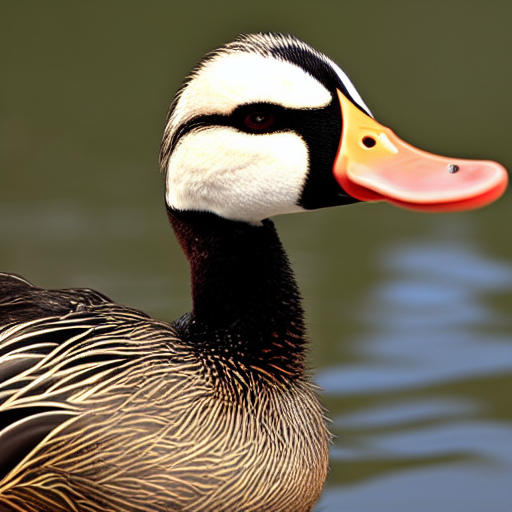

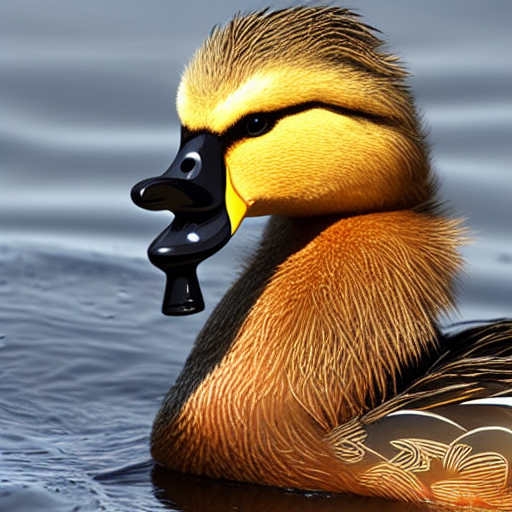

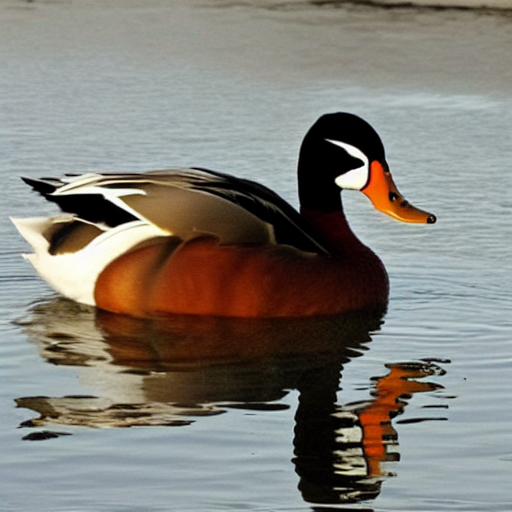

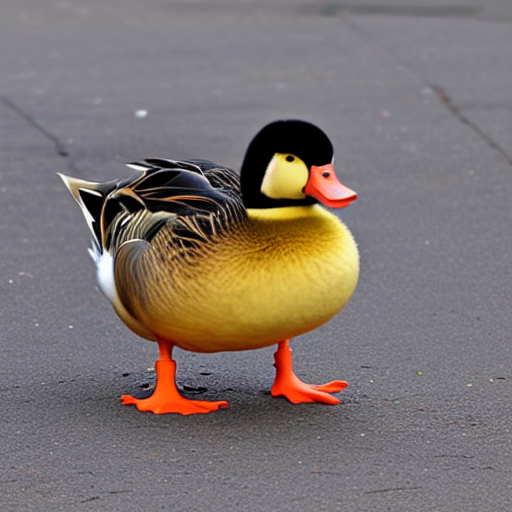

In [100]:
# out = pipe("an egg walking around on the moon", num_inference_steps=32)
out = pipe("angry duck", num_inference_steps=32, num_images_per_prompt=4)
for i in out["images"]:
    display(i)

We can reproduce results by using a controllable random number generator:

  0%|          | 0/32 [00:00<?, ?it/s]

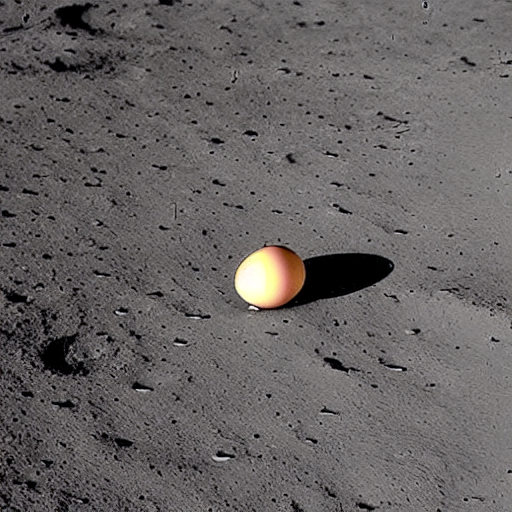

In [53]:
generator = torch.Generator().manual_seed(1010)
out = pipe("an egg walking around on the moon", num_inference_steps=32, generator=generator)
display(out["images"][0])

## Control Net

Almost like add-ons/plugins for the Stable-Diffusion architecture.

Expands our options for guiding the model.

#### [Scribble](https://huggingface.co/lllyasviel/sd-controlnet-scribble)

<img src="./imgs/scribble_00.jpg" width="200px">
<img src="./imgs/scribble_01.jpg" width="200px">

#### [Depth](https://huggingface.co/lllyasviel/sd-controlnet-depth)

<img src="./imgs/depth_00.jpg" width="200px">
<img src="./imgs/depth_01.jpg" width="200px">

In [20]:
controlnet = ControlNetModel.from_pretrained(
  "lllyasviel/sd-controlnet-scribble",
  # "lllyasviel/sd-controlnet-depth",
  torch_dtype=torch.float16
)

pipe = SDCNPipeline.from_pretrained(
  "runwayml/stable-diffusion-v1-5",
  controlnet=controlnet,
  safety_checker=None,
  torch_dtype=torch.float16
).to("cuda")

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

C:\Users\MC PostLab\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MC PostLab\.cache\huggingface\hub\models--lllyasviel--sd-controlnet-scribble. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [27]:
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/20 [00:00<?, ?it/s]

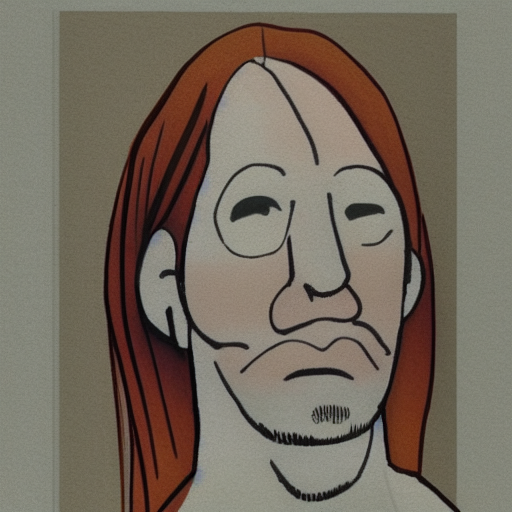

In [28]:
im = Image.open("./imgs/scribble_01.jpg").convert("RGB")
out = pipe("person", im, num_inference_steps=20)
display(out["images"][0])

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

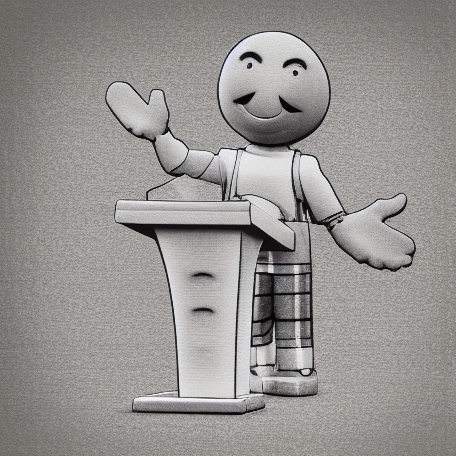

In [ ]:
controlnet = ControlNetModel.from_pretrained(
#   "lllyasviel/sd-controlnet-scribble",
  "lllyasviel/sd-controlnet-depth",
  torch_dtype=torch.float16
)

pipe = SDCNPipeline.from_pretrained(
  "runwayml/stable-diffusion-v1-5",
  controlnet=controlnet,
  safety_checker=None,
  torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)


  0%|          | 0/20 [00:00<?, ?it/s]

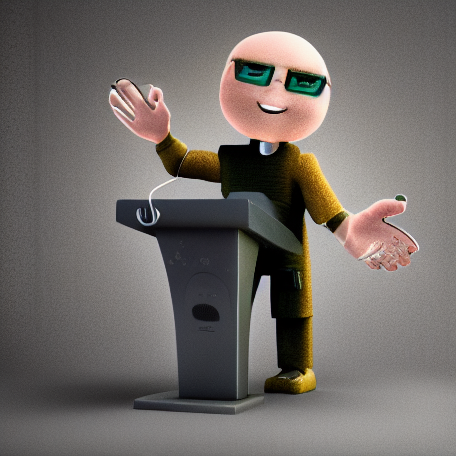

In [80]:
im = Image.open("./imgs/depth_00.jpg").convert("RGB")
out = pipe("person", im, num_inference_steps=20)
display(out["images"][0])

## [SD Turbo](https://huggingface.co/stabilityai/sd-turbo)

Distilled version of Stable-Diffusion.

https://www.reddit.com/r/StableDiffusion/comments/1e6cq09/physical_interfaces_realtime_img2img_diffusion/

In [29]:
pipe = AutoPipelineForText2Image.from_pretrained(
  "stabilityai/sd-turbo",
  # "stabilityai/sdxl-turbo",
  torch_dtype=torch.float16,
  variant="fp16"
).to("cuda")

model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

C:\Users\MC PostLab\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MC PostLab\.cache\huggingface\hub\models--stabilityai--sd-turbo. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

unet%2Fconfig.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

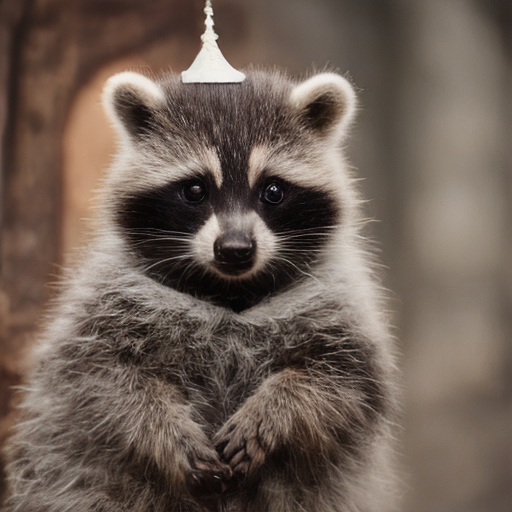

In [30]:
prompt = "A cinematic shot of a baby racoon wearing an intricate italian priest robe."
out = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0, num_images_per_prompt=4)
display(out["images"][0])

In [31]:
pipe = AutoPipelineForImage2Image.from_pretrained(
  "stabilityai/sd-turbo",
  # "stabilityai/sdxl-turbo",
  torch_dtype=torch.float16,
  variant="fp16"
).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

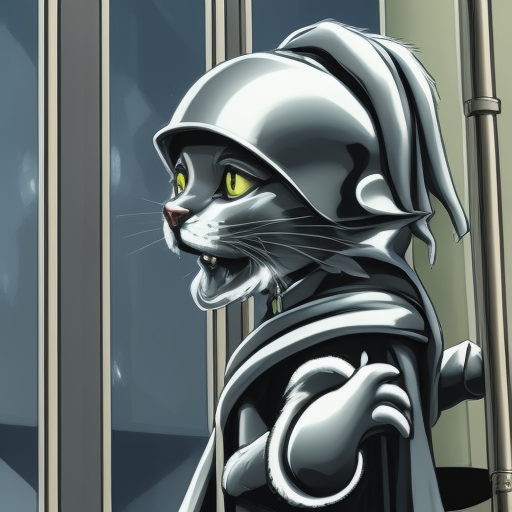

In [32]:
im = Image.open("./imgs/scribble_01.jpg").convert("RGB")
prompt = "cat wizard, gandalf, lord of the rings, detailed, fantasy, cute, adorable, Pixar, Disney, 8k"
out = pipe(prompt, image=im, num_inference_steps=2, strength=0.5, guidance_scale=0.0)
display(out["images"][0])

## [Inpainting](https://huggingface.co/docs/diffusers/en/using-diffusers/inpaint)

Only generate parts of an image.

In [81]:
pipe = AutoPipelineForInpainting.from_pretrained(
  #"runwayml/stable-diffusion-inpainting",
  #"stable-diffusion-v1-5/stable-diffusion-inpainting",
  "stabilityai/stable-diffusion-2-inpainting",
  torch_dtype=torch.float16,
  variant="fp16"
).to("cuda")

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

C:\Users\MC PostLab\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MC PostLab\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

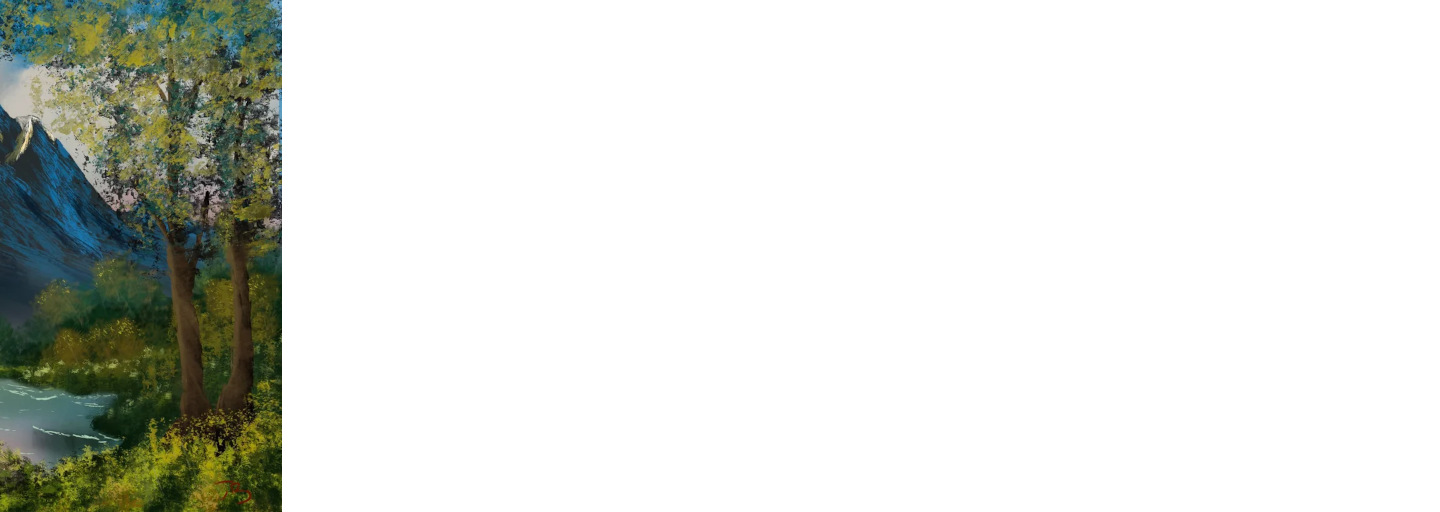

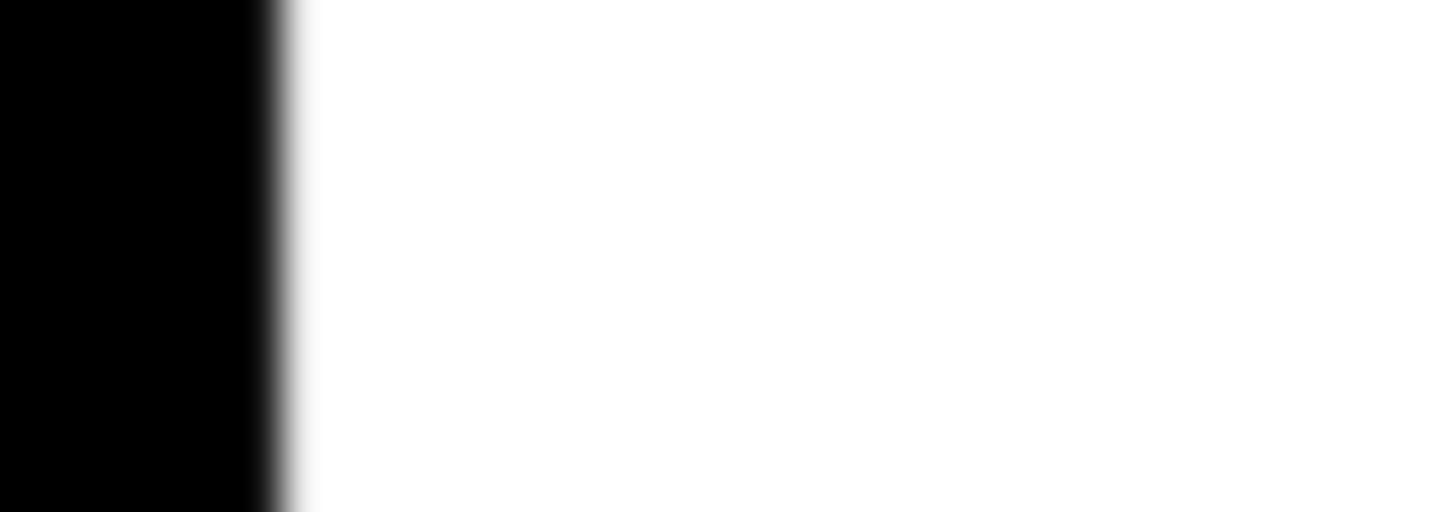

In [82]:
im = Image.open("./imgs/landscape.jpg")
mask = Image.open("./imgs/landscape_mask.jpg").filter(ImageFilter.GaussianBlur((16,0)))
iw,ih = im.size

display(im)
display(mask)

  0%|          | 0/24 [00:00<?, ?it/s]

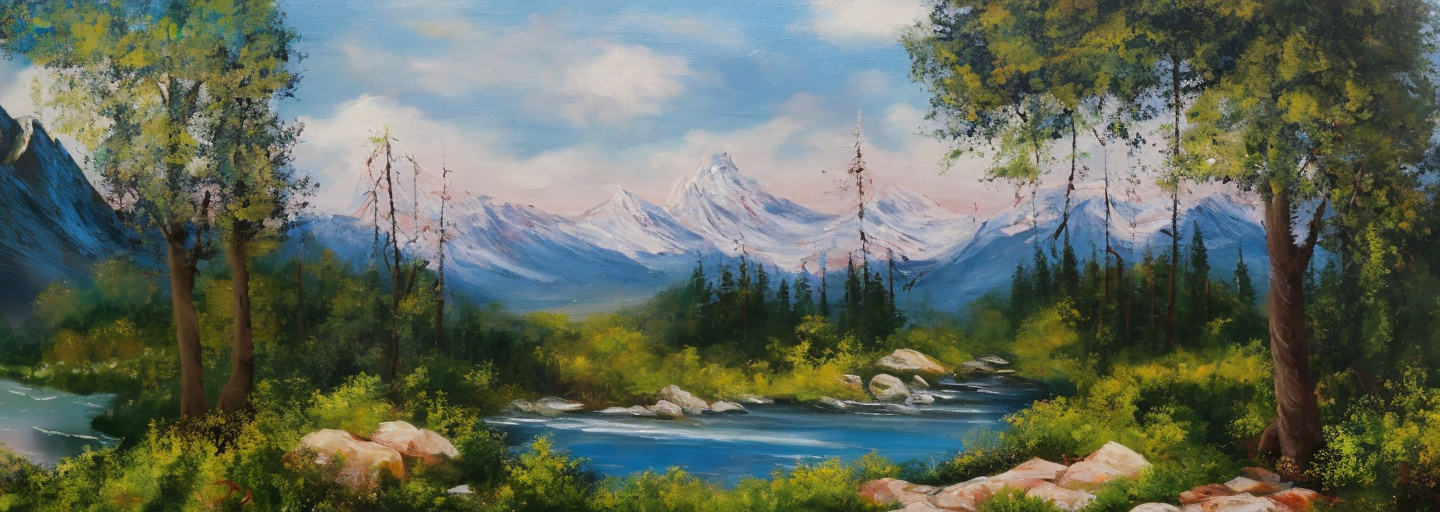

In [83]:
prompt = "bob ross oil painting of nature landscape with trees, detailed brushstrokes, mountains, lake, rocks"
output = pipe(prompt=prompt, image=im, mask_image=mask, num_inference_steps=24, width=iw, height=ih)
display(output.images[0])

## [Image Variation](https://huggingface.co/lambdalabs/sd-image-variations-diffusers)

Get variations of an image.

In [84]:
pipe = SDIVPipeline.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  safety_checker=None
).to("cuda")

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

C:\Users\MC PostLab\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MC PostLab\.cache\huggingface\hub\models--lambdalabs--sd-image-variations-diffusers. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\MC PostLab\.cache\huggingface\hub\models--lambdalabs--sd-image-variations-diffusers\snapshots\a2a13984e57db80adcc9e3f85d568dcccb9b29fc\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\MC PostLab\.cache\huggingface\hub\models--lambdalabs--sd-image-variations-diffusers\snapshots\a2a13984e57db80adcc9e3f85d568dcccb9b29fc\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\MC PostLab\.cache\huggingface\hub\models--lambdalabs--sd-image-variations-diffusers\snapshots\a2a13984e57db80adcc9e3f85d568dcccb9b29fc\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\MC PostLab\.cache\huggingface\hub\models--lambdalabs--sd-image-variations-diffusers\snapshots\a2a13984e57db80adcc9e3f85d568dcccb9b29fc\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error ins

In [85]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [90]:
im = Image.open("./imgs/depth_01.jpg")
input = SDIVProcessor(im).to("cuda").unsqueeze(0)

  0%|          | 0/32 [00:00<?, ?it/s]

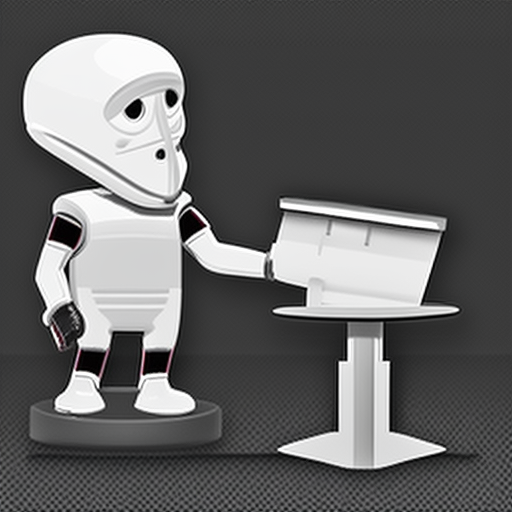

In [91]:
out = pipe(input, guidance_scale=3, num_inference_steps=32)
display(out["images"][0])